# Retrieving dust proparties from interferometric visibilities

In this page, we aim to retrieve dust proparties such as surface densities as a function of radius by directly fitting the FRAPPE model to the interferometric visibilities. We assume that the data have already been averaged and deprojected (see [Data preparation](tutorial_0.ipynb)).

## 1. Import modules and data

First, we import several modules in addition to FRAPPE.

In [ ]:
import frappe
import numpyro
import pickle
import dsharp_opac
import jax.numpy as jnp

We then set the number of the CPUs (or GPU devices if you have) for parallel calcuration. I'm currently running this notebook on a Macbook Pro and it has 8 cores, so I set "8".

In [3]:
numpyro.set_host_device_count(8)

We have observations of the HD169142 disk in two bands: ALMA band 3 and 6. 
For a better management of the data, we set a list and corresponding dictonary. You should of course change the file paths depending your environment.

In [4]:
bands = [ 'band3', 'band6' ]
data = {
    'band3' : '../../example_data/HD169142_band3.pkl',
    'band6' : '../../example_data/HD169142_band6.pkl'
}

Let's load the files to a dictionally.

In [5]:
obs = {}

for band in bands:
    with open(data[band], 'rb') as f:
        obs[band] = pickle.load(f)
        

The data structure depends on how did you make the pkl file. However, if you followed the turorial, you have keys something like this:

In [6]:
obs['band3'].keys(), obs['band3']['q'].keys()

(dict_keys(['q', 'V', 's', 'nu', 'Nch']), dict_keys([0, 1]))

'q', 'V', 's', 'nu', and 'Nch' are the uv distance, real part of the visibilities, standard deviation, frequency, and number of channels. Each channels are stored as a dictionary in each element.

We assume the dust opacity model. Here we adopt [the DSHARP opacity](https://github.com/birnstiel/dsharp_opac). 

In [7]:
dust_opacity = jnp.load(dsharp_opac.get_datafile('default_opacities_smooth.npz'))

## 2. Set the disk model

Then we set the FRAPPE disk model which we'll fit to the data. First, we do some calcuration setting. We assume the inclination angle of 6.28 deg and the outer disk edge of 1.3 arcsec. We'll set a length scale of the gaussian process to be 0.04 arcsec later, therefore, we set the number of sampling point of the Gaussian process to be 130 so that the typical seperation becomes ~0.01 arcsec. Note that the radial grid is not perfectly evenly spaced.

In [8]:
disk = frappe.model( incl= 6.28,
                     r_out = 1.3,
                     N_GP = 130,
                     flux_uncert = True )

In this tutorial, we have only two bands - band 3 and 6. This is not really sufficient to constrain many parameters. So, let's fix the temperature profile in advance. Such parameters can be added like this:

In [9]:
D = 114.9 # pc

disk.set_parameter('log10_T', 
                   free = False, 
                   profile = lambda r: jnp.log10(77.0*(r*D/10)**(-0.5)) )

We assume the bestfit value in a previous study for this disk by [Macías et al. (2019)](https://iopscience.iop.org/article/10.3847/1538-4357/ab31a2/meta). The input "profile" can also support a jnp.ndarray.

We should also fix the power-law profile of the dust size distribution, q, to be the MRN distribution of 3.5.

In [10]:
disk.set_parameter('q', 
                   free = False, 
                   profile = lambda r: 3.5 )

We instead try to fit the gas surface densities and the maximum grain size in this tutorial. We adopt a lengthscale of 0.04 arcsec in this example, but you may change depending on your interest. The parameter "bounds" is a tuple of the lower and upper limit of the parameter. The lower bound of a_max is set to be 100 um. This might be important particularly for this example since there are two possible solutions and the gaussian process sometimes can't manage this situation. Note that we assume CGS units.

In [11]:
lengthscale = 0.03

disk.set_parameter('log10_Sigma_d', free = True,
                                    bounds = ( -6.0, 3.0 ), 
                                    lengthscale = lengthscale)

disk.set_parameter('log10_a_max', free = True, 
                                    bounds =  ( -2.0, 2.0 ),
                                    lengthscale = lengthscale)

We set the observational data for each band. The inputs q, V, s assume a dictionary of channel indices. Simutaneously, we can set the absolute flux scaling factors and its uncertainty.

In [ ]:
f_s = { 'band3': 0.025, 'band6': 0.05 }
f_mean = { 'band3': 1.0, 'band6': 1.0 }
    
for band in bands:
    disk.set_visibility( band = band,
                            q = obs[band]['q'],
                            V = obs[band]['V'],
                            s = obs[band]['s'],
                            nu = obs[band]['nu'],
                            Nch = obs[band]['Nch'],
                            f_s = f_s[band],
                            f_mean = f_mean[band] )

The last thing that FRAPPE has to know is the opacity. As it depends on the frequency of the data, we have to run this after set_observations. By default, this function performs smoothing of the opacities along the dust size direction with a width of $\log_{\rm 10}(a) = 0.05$. This is to avoid the wiggling due to Mie interference as it makes the Hamiltonian "bumpy" and affects sampling.

In [13]:
disk.set_opacity( opac_dict = dust_opacity )

## 3. Run MCMC sampling

Now the model is all set! We launch the inference function.

In [14]:
inference = frappe.inference(disk)

Before running MCMC sampling, we should check the priors.

In [15]:
prior = inference.prior(num_samples=10)
plotter = frappe.plot( prior )

saved keys:  dict_keys(['prior_f', 'prior_g'])


`frappe.plot()` shows what samples you can see. If you are interested in the prior of the function of the physical quantities, chose 'prior_f'. On the other hand, 'prior_g' is the latent function of the gaussian process.

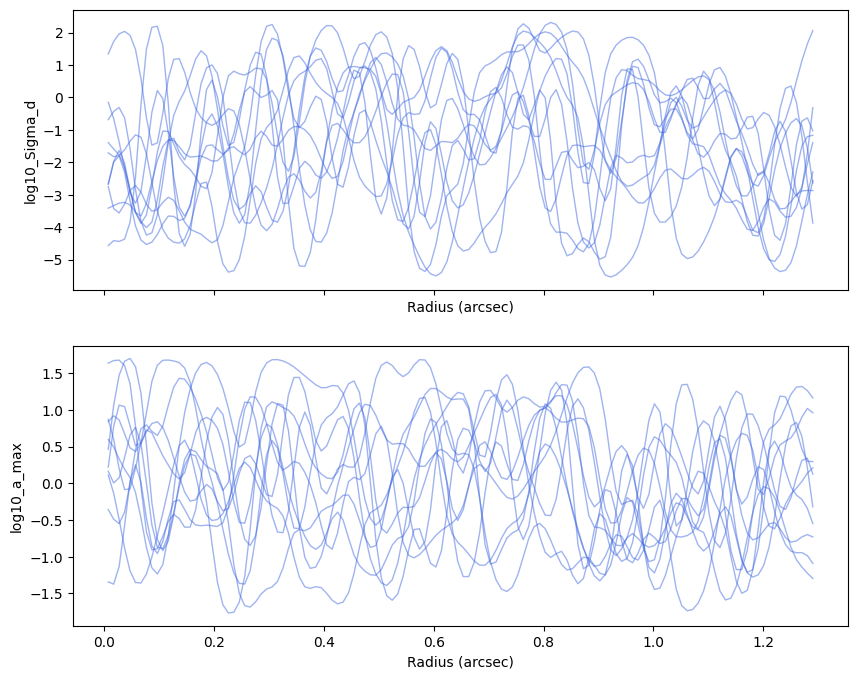

In [16]:
plotter.sample_paths( 'prior_f', nskip = 1 )

If you are satisfied with this, let's start the MCMC sampling! "num_chains" is set to be the same as the number of your CPU cores.

In [17]:
num_warmup = 5000
num_samples = 5000
num_chains = 8

posterior = inference.MCMC( num_warmup = num_warmup, 
                            num_samples = num_samples,
                            num_chains = num_chains )


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
       g_f_scale_band3      9.42      0.25      9.42      9.00      9.82    478.29      1.03
       g_f_scale_band6      6.26      0.11      6.26      6.09      6.44    131.93      1.03
  g_log10_Sigma_d_z[0]      0.57      0.02      0.57      0.53      0.61    819.65      1.01
  g_log10_Sigma_d_z[1]     -0.87      0.27     -0.84     -1.27     -0.47    395.27      1.02
  g_log10_Sigma_d_z[2]     -1.11      0.74     -1.09     -2.31      0.11    119.76      1.05
  g_log10_Sigma_d_z[3]     -0.91      0.84     -0.92     -2.29      0.48     35.59      1.09
  g_log10_Sigma_d_z[4]     -0.52      0.92     -0.52     -2.03      0.99     35.31      1.16
  g_log10_Sigma_d_z[5]     -0.63      0.86     -0.63     -2.09      0.75     51.89      1.09
  g_log10_Sigma_d_z[6]     -0.79      0.94     -0.78     -2.31      0.75     15.13      1.20
  g_log10_Sigma_d_z[7]     -0.55      0.82     -0.56     -1.86      0

In my case (MacBook Pro, M3), it tooks a few ten-minutes to run this. Note that the time needed for convergence significantly depends on the problem.

## 4. Inspect the results

Finally, we inspect the results. We can plot the posterior distribution as follows.

In [18]:
plotter = frappe.plot( posterior )

saved keys:  dict_keys(['warmup_f', 'posterior_f', 'warmup_g', 'posterior_g'])


We want to see the posterior of the physical quantities, therefore,

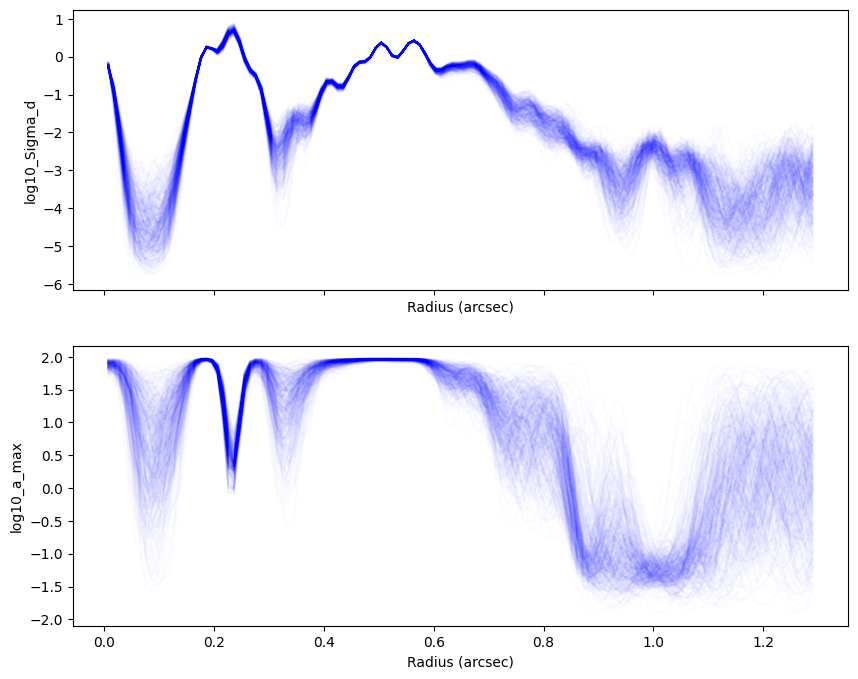

In [20]:
plotter.sample_paths( 'posterior_f', nskip = 100, plot_kwargs = { 'alpha' : 0.01, 'color' : 'b' } )

`posterior` has those results and you can save it.

In [ ]:
with open('./mcmc_reuslts.pkl', 'wb') as f:
    pickle.dump( posterior, f )